# Zadanie: PCA
Dodaj PCA do problemu klasyfikacji i regresji z poprzednich modułów.

In [4]:
!pip install prettytable

Dane wczytane pomyślnie

Podstawowe informacje o danych:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
 4   Species        344 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 13.6 KB
None

Liczba brakujących wartości:
CulmenLength     2
CulmenDepth      2
FlipperLength    2
BodyMass         2
Species          0
dtype: int64

Statystyki opisowe:
       CulmenLength  CulmenDepth  FlipperLength     BodyMass     Species
count    342.000000   342.000000     342.000000   342.000000  342.000000
mean      43.921930    17.151170     200.915205  4201.754386    0.757310
std        5.459584     1.974793      14.061714   801.954536    0.763648
min       32.100000    1

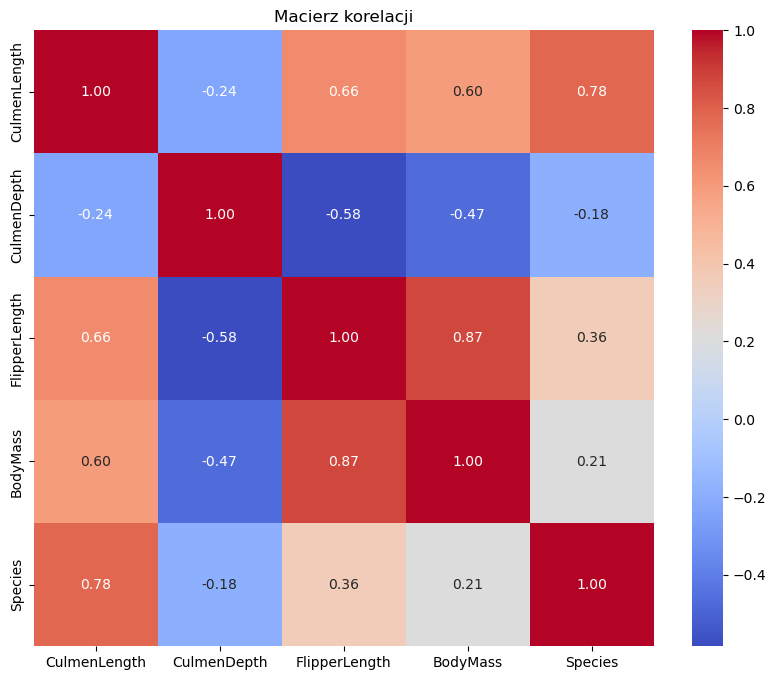

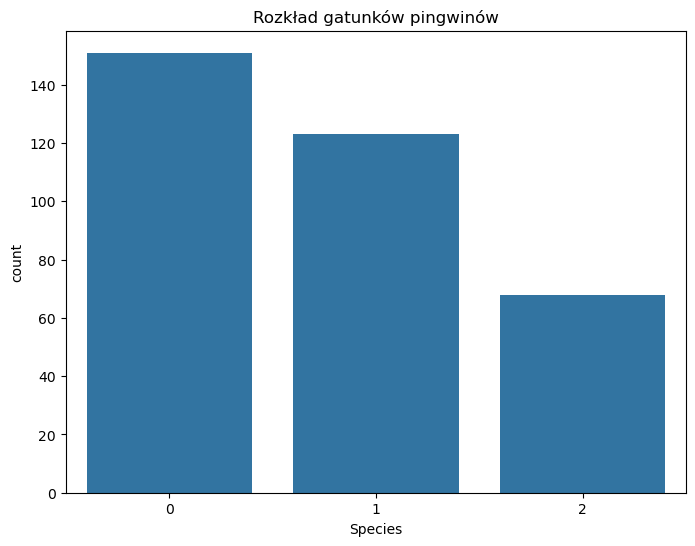

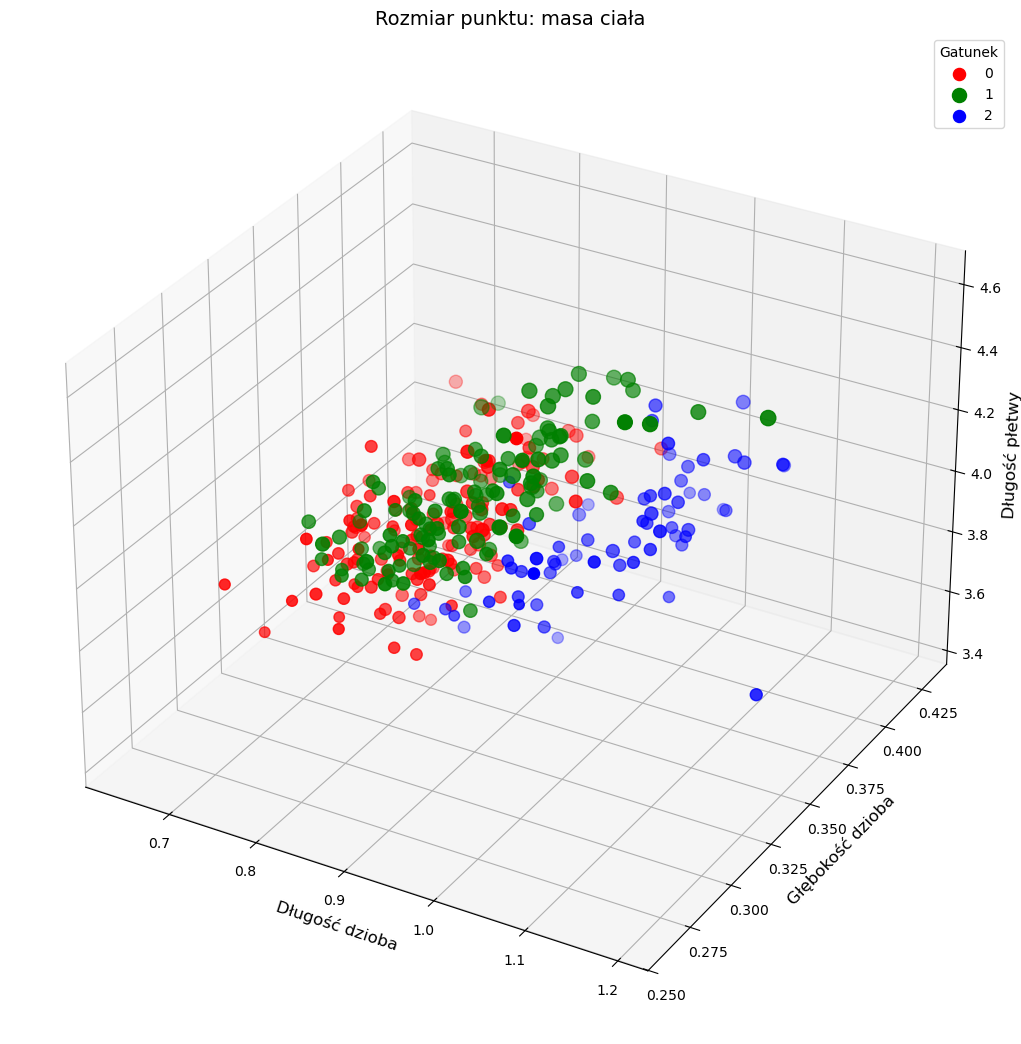


Generowanie pairplot... (może chwilę potrwać)


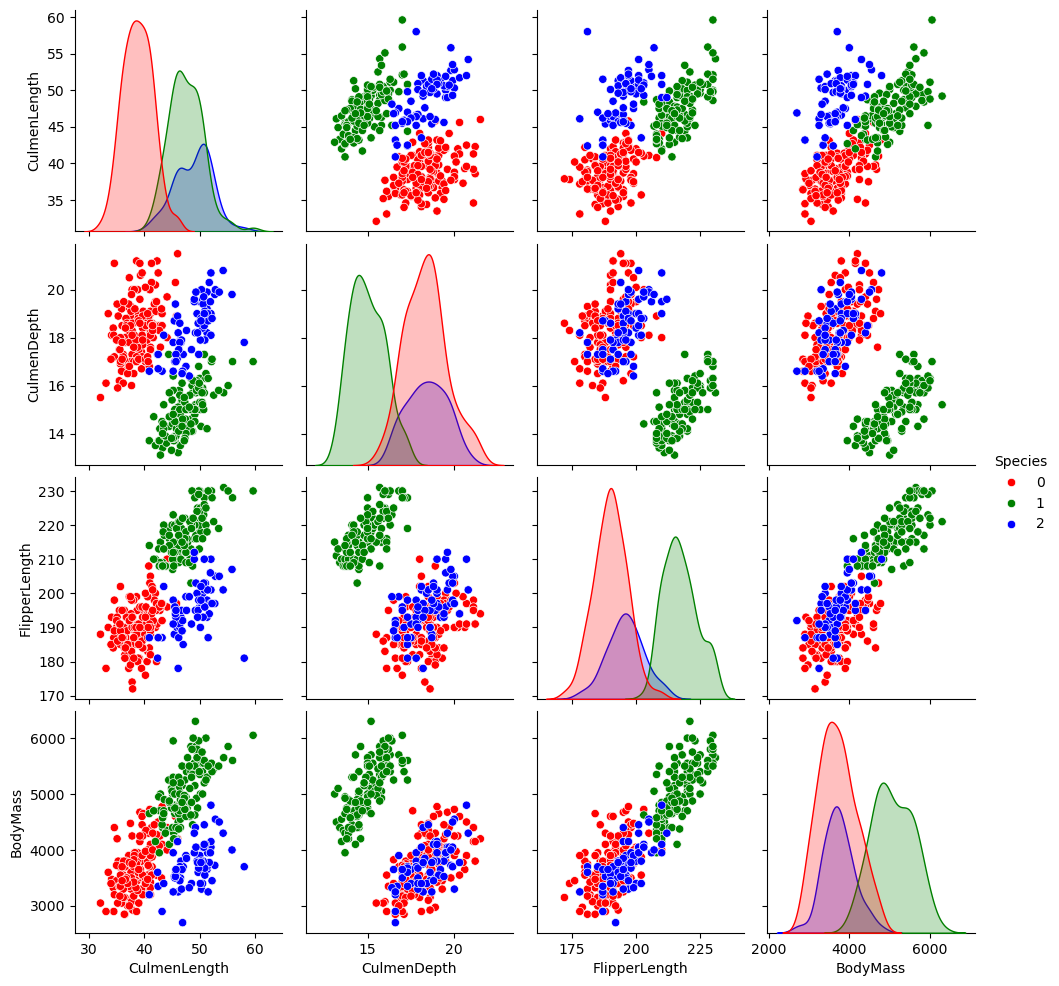

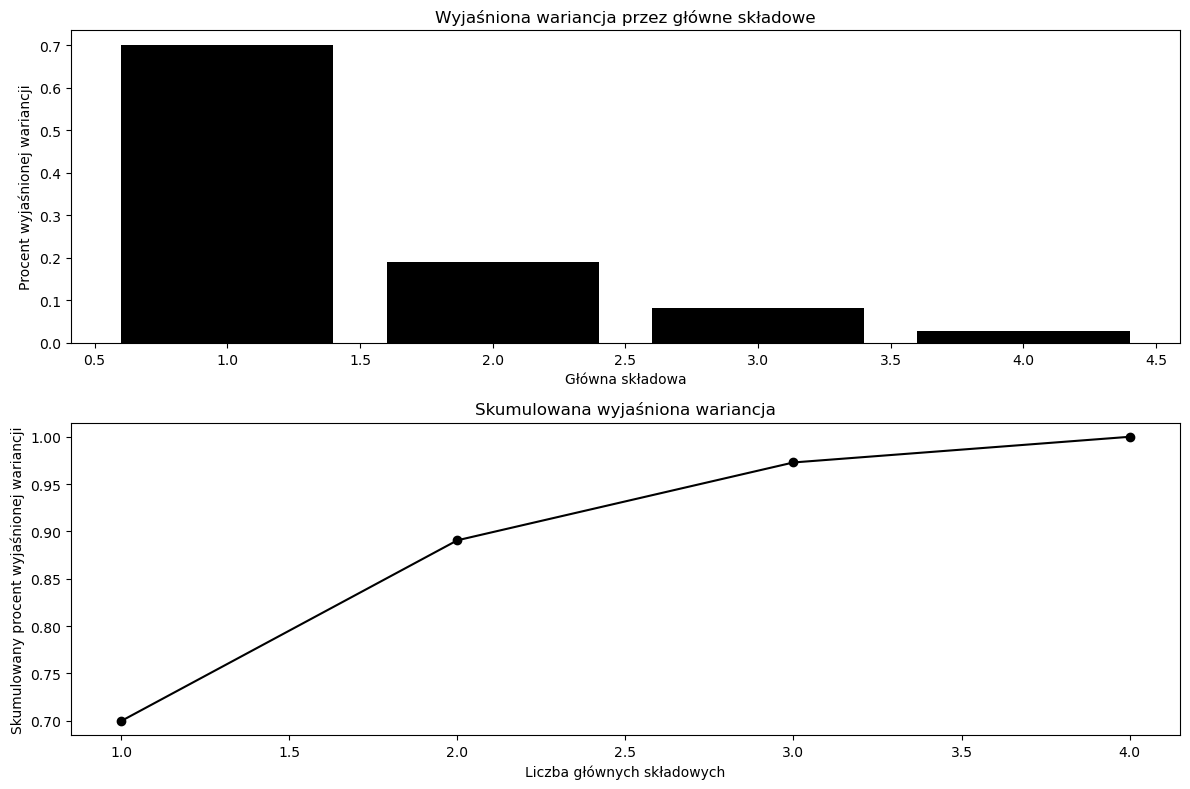

Porównanie modeli regresji logistycznej:
+-------------------+------------+----------------------+
|       Model       | Dokładność | Czas trenowania (μs) |
+-------------------+------------+----------------------+
| Nieskalowane dane |   0.9942   |        71510         |
|   Skalowane dane  |    1.0     |         1998         |
| 4 główne składowe |    1.0     |         1000         |
| 3 główne składowe |   0.9942   |         1000         |
| 2 główne składowe |   0.9181   |         1000         |
| 1 główne składowe |   0.9298   |         1000         |
+-------------------+------------+----------------------+

Porównanie modeli regresji liniowej:
+-------------------+----------+--------+----------------------+
|       Model       | R2 Score |  MSE   | Czas trenowania (μs) |
+-------------------+----------+--------+----------------------+
| Nieskalowane dane |  0.744   | 0.1492 |         1000         |
|   Skalowane dane  |  0.744   | 0.1492 |          0           |
| 4 główne skład

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from prettytable import PrettyTable
import datetime

%matplotlib inline

# Wczytanie danych
try:
    penguins = pd.read_csv('penguins.csv')
    print("Dane wczytane pomyślnie")
except FileNotFoundError:
    print("Nie znaleziono pliku penguins.csv. Upewnij się, że znajduje się w tym samym folderze co notebook.")
    raise

# Podstawowe informacje o danych
print("\nPodstawowe informacje o danych:")
print(penguins.info())
print("\nLiczba brakujących wartości:")
print(penguins.isnull().sum())

# Usunięcie wierszy z brakującymi wartościami
penguins = penguins.dropna()

# Statystyki opisowe
print("\nStatystyki opisowe:")
print(penguins.describe())

# Rozkład klas
print("\nRozkład gatunków pingwinów:")
print(penguins['Species'].value_counts(normalize=True))

# Analiza korelacji
print("\nMacierz korelacji:")
correlation_matrix = penguins.corr(numeric_only=True)
print(correlation_matrix)

# Wizualizacja macierzy korelacji
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Macierz korelacji')
plt.show()

# Wizualizacja rozkładu gatunków
plt.figure(figsize=(8, 6))
sns.countplot(x='Species', data=penguins)
plt.title('Rozkład gatunków pingwinów')
plt.show()

# Wykres 3D
fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, projection='3d')

species_colors = {0: 'red', 1: 'green', 2: 'blue'}
for species, color in species_colors.items():
    species_data = penguins[penguins['Species'] == species]
    ax.scatter(xs=species_data['CulmenLength']/50,
               ys=species_data['CulmenDepth']/50,
               zs=species_data['FlipperLength']/50,
               s=species_data['BodyMass']/50,
               c=color, label=str(species))

ax.set_xlabel('Długość dzioba', size=12)
ax.set_ylabel('Głębokość dzioba', size=12)
ax.set_zlabel('Długość płetwy', size=12)
ax.set_title('Rozmiar punktu: masa ciała', size=14)
plt.legend(title='Gatunek')
plt.show()

# Wykres pairplot
print("\nGenerowanie pairplot... (może chwilę potrwać)")
sns.pairplot(penguins, hue='Species', palette=species_colors)
plt.show()

# Przygotowanie danych do modelowania
X = penguins.drop('Species', axis=1)
y = penguins['Species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

# Skalowanie danych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Analiza PCA
pca = PCA(random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Wizualizacja PCA
plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, color='black')
plt.title('Wyjaśniona wariancja przez główne składowe')
plt.xlabel('Główna składowa')
plt.ylabel('Procent wyjaśnionej wariancji')

plt.subplot(2, 1, 2)
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
         np.cumsum(pca.explained_variance_ratio_), 'o-', color='black')
plt.title('Skumulowana wyjaśniona wariancja')
plt.xlabel('Liczba głównych składowych')
plt.ylabel('Skumulowany procent wyjaśnionej wariancji')
plt.tight_layout()
plt.show()

# Porównanie modeli - regresja logistyczna (zoptymalizowane parametry)
def train_and_check(Xtrain, Xtest, ytrain, ytest):
    classifier = LogisticRegression(max_iter=5000, solver='lbfgs', penalty='l2', C=1.0)
    start = datetime.datetime.now()
    classifier.fit(Xtrain, ytrain)
    end = datetime.datetime.now()
    time = (end - start).microseconds
    evaluation = np.round(classifier.score(Xtest, ytest), 4)
    return evaluation, time

results = PrettyTable(['Model', 'Dokładność', 'Czas trenowania (μs)'])
results.add_row(['Nieskalowane dane', *train_and_check(X_train, X_test, y_train, y_test)])
results.add_row(['Skalowane dane', *train_and_check(X_train_scaled, X_test_scaled, y_train, y_test)])

for n in range(4, 0, -1):
    results.add_row([f'{n} główne składowe', 
                   *train_and_check(X_train_pca[:, :n], 
                   X_test_pca[:, :n], y_train, y_test)])

print("Porównanie modeli regresji logistycznej:")
print(results)

# Porównanie modeli - regresja liniowa
def train_and_check_linreg(Xtrain, Xtest, ytrain, ytest):
    model = LinearRegression()
    start = datetime.datetime.now()
    model.fit(Xtrain, ytrain)
    end = datetime.datetime.now()
    time = (end - start).microseconds
    pred = model.predict(Xtest)
    r2 = np.round(r2_score(ytest, pred), 4)
    mse = np.round(mean_squared_error(ytest, pred), 4)
    return r2, mse, time

linreg_results = PrettyTable(['Model', 'R2 Score', 'MSE', 'Czas trenowania (μs)'])
linreg_results.add_row(['Nieskalowane dane', *train_and_check_linreg(X_train, X_test, y_train, y_test)])
linreg_results.add_row(['Skalowane dane', *train_and_check_linreg(X_train_scaled, X_test_scaled, y_train, y_test)])

for n in range(4, 0, -1):
    linreg_results.add_row([f'{n} główne składowe', 
                          *train_and_check_linreg(X_train_pca[:, :n], 
                          X_test_pca[:, :n], y_train, y_test)])

print("\nPorównanie modeli regresji liniowej:")
print(linreg_results)